In [23]:
import matplotlib.pyplot as plt
import numpy as np

from qibo import callbacks, hamiltonians, models, set_backend, gates
set_backend("numpy")

[Qibo 0.1.15|INFO|2023-07-11 18:10:50]: Using numpy backend on /CPU:0


## Adiabatic Quantum Computing

## First example:
from X to TFIM

In [2]:
nqubits = 4
hfield = 1
dt = 1e-1
solver = "exp"
T = 10

Text(0, 0.5, 'Overlap')

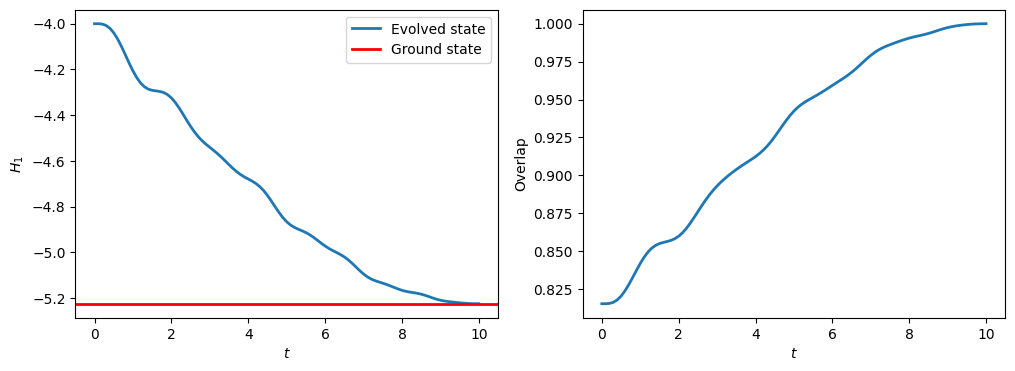

In [3]:
h0 = hamiltonians.X(nqubits)
h1 = hamiltonians.TFIM(nqubits, h=hfield)
bac = h1.backend

# Calculate target values (H1 ground state)
target_state = h1.ground_state()
target_energy = bac.to_numpy(h1.eigenvalues()[0]).real

# Check ground state
state_energy = bac.to_numpy(h1.expectation(target_state)).real
np.testing.assert_allclose(state_energy.real, target_energy)

energy = callbacks.Energy(h1)
overlap = callbacks.Overlap(target_state)
evolution = models.AdiabaticEvolution(
    h0, h1, lambda t: t, dt=dt, solver=solver, callbacks=[energy, overlap]
)
final_psi = evolution(final_time=T)
# Plots
tt = np.linspace(0, T, int(T / dt) + 1)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(tt, energy[:], linewidth=2.0, label="Evolved state")
plt.axhline(y=target_energy, color="red", linewidth=2.0, label="Ground state")
plt.xlabel("$t$")
plt.ylabel("$H_1$")
plt.legend()

plt.subplot(122)
plt.plot(tt, overlap[:], linewidth=2.0)
plt.xlabel("$t$")
plt.ylabel("Overlap")

## Adiabatic Grover

In [4]:
from qibo.hamiltonians import Hamiltonian
import numpy as np
def plus_state(nqubits):
    circuit1 = models.Circuit(nqubits)
    circuit1.add(gates.H(i) for i in range(nqubits))
    state = circuit1().state()
    return state

def get_density_matrix(state):
    return np.outer(state, state)

In [11]:
nqubits = 2

In [12]:
initial_state = plus_state(nqubits)

In [13]:
h0 = Hamiltonian(nqubits, matrix=np.eye(2**nqubits)-np.outer(initial_state, initial_state))

In [14]:
final_state = np.array([0,1,0,0])
h1 = Hamiltonian(2, matrix=np.eye(4) - np.outer(final_state,final_state))

In [15]:
target_state = h1.ground_state()
target_energy = h1.eigenvalues()[0]
state_energy = h1.expectation(target_state)
np.testing.assert_allclose(state_energy, target_energy)

In [16]:
energy_callback = callbacks.Energy(h1)
T = 100
dt = 1e-1
evolution = models.AdiabaticEvolution(h0,h1, lambda t :t, dt,callbacks=[energy_callback])
final_psi = evolution(T)

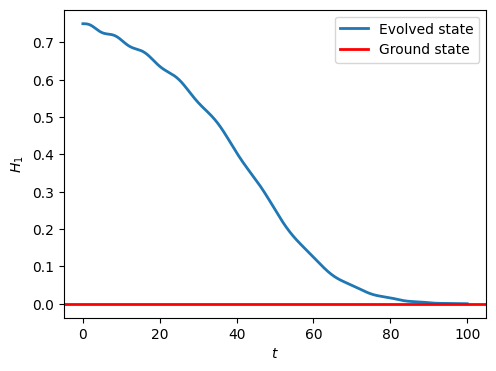

In [17]:
tt = np.linspace(0, T, int(T / dt) + 1)
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(tt, energy_callback[:], linewidth=2.0, label="Evolved state")
plt.axhline(y=target_energy, color="red", linewidth=2.0, label="Ground state")
plt.xlabel("$t$")
plt.ylabel("$H_1$")
plt.legend()

In [18]:
def spolynomial(t, params):
    """General polynomial scheduling satisfying s(0)=0 and s(1)=1"""
    f = sum(p * t ** (i + 2) for i, p in enumerate(params))
    f += (1 - np.sum(params)) * t
    return f

In [19]:
solver = "exp"
method = "Powell"
energy_callback = callbacks.Energy(h1)
params =[1,2]
evolution = models.AdiabaticEvolution(h0, h1, spolynomial, dt=dt, solver=solver,callbacks=[energy_callback])
energy, parameters, _ = evolution.minimize(
    params, messages=True
)

[Qibo 0.1.15|INFO|2023-07-11 11:44:45]: Params: [1. 2.]  -  <H1> = 0.7099003459274988
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [1.00000001 2.        ]  -  <H1> = 0.7099003465014628
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [1.         2.00000001]  -  <H1> = 0.7099003455166082
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [0.96148193 2.02757441]  -  <H1> = 0.7077101472803229
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [0.96148194 2.02757441]  -  <H1> = 0.7077101478490392
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [0.96148193 2.02757442]  -  <H1> = 0.7077101469193002
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [0.80740964 2.13787203]  -  <H1> = 0.6972933794290327
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [0.80740966 2.13787203]  -  <H1> = 0.6972933799658486
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [0.80740964 2.13787204]  -  <H1> = 0.6972933789869988
[Qibo 0.1.15|INFO|2023-07-11 11:44:46]: Params: [0.19112051 2.57906251]  -  <H1> = 0.6552765114195

In [20]:
final_state = evolution(parameters[-1])

In [21]:
T = parameters[-1]

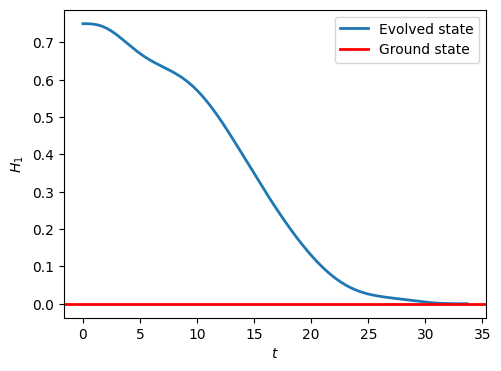

In [22]:
tt = np.linspace(0, T, int(T / dt) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(tt, energy_callback[-len(tt):], linewidth=2.0, label="Evolved state")
plt.axhline(y=target_energy, color="red", linewidth=2.0, label="Ground state")
plt.xlabel("$t$")
plt.ylabel("$H_1$")
plt.legend()